In [28]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock
from tqdm import tqdm

#Data Loading and Preprocessing
dataset = pd.read_csv('/Users/sarahadrianne/Desktop/album_to_track_df.csv')
print(dataset.head())
dataset.drop(columns=['Unnamed: 0'], inplace=True)

##Check for null values
print(dataset.isna().sum())
dataset_null = dataset[dataset.isnull().any(axis=1)]
print(dataset_null.head(n=10)) #since null values are minimal, we can drop them

dataset.dropna(inplace = True)

   Unnamed: 0  Artist               Artist_Id                 Album_Name  \
0           0  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
1           1  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
2           2  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
3           3  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
4           4  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   

                 Album_Id                                        Track_Title  \
0  697cPaD568S5Zt4bgo4cQf                                     Opening - Live   
1  697cPaD568S5Zt4bgo4cQf                                      I yah! - Live   
2  697cPaD568S5Zt4bgo4cQf           Git It Up! / 전사의 후예 / You Got Gun - Live   
3  697cPaD568S5Zt4bgo4cQf                                Opening Ment - Live   
4  697cPaD568S5Zt4bgo4cQf  It's Been Raining Since You Left Me / Delight ...   

                 Track_Id  danceability  energy   key  loudnes

In [29]:
## Remove duplicates since there are a lot
dataset.drop_duplicates(subset=['Artist', 'Track_Title'], inplace=True)

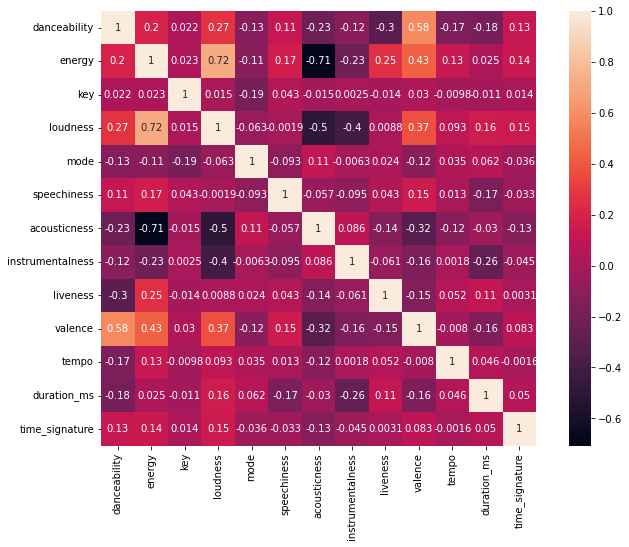

In [30]:
#Initial EDA
##Checking for correlation
feat_corr_matrix = dataset.drop(columns=['Artist', 'Artist_Id', 'Album_Name', 'Album_Id', 'Track_Title', 'Track_Id']).corr()
plt.subplots(figsize=(12,8))
seaborn.heatmap(feat_corr_matrix, annot=True, square=True)
plt.show()

Strongly positively correlated (>=.5): energy & loudness, valence & danceability
Strongly Negatively correlated(<=-.5): energy & acousticness, acousticness & loudness

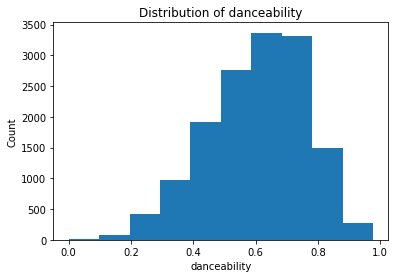

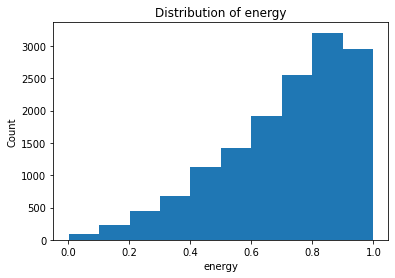

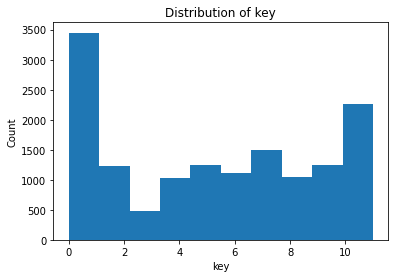

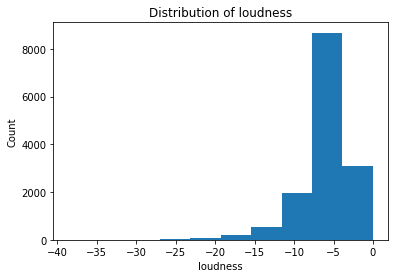

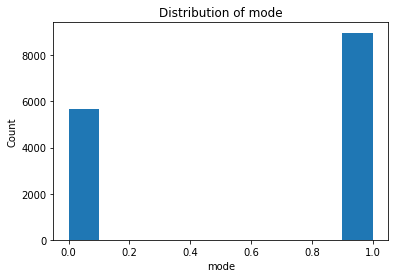

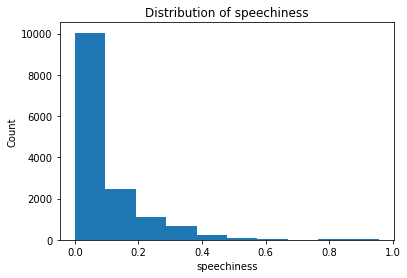

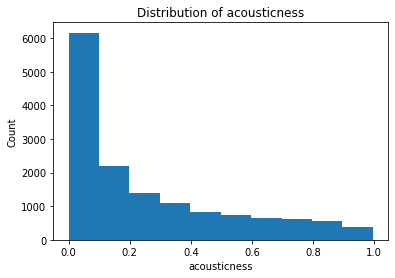

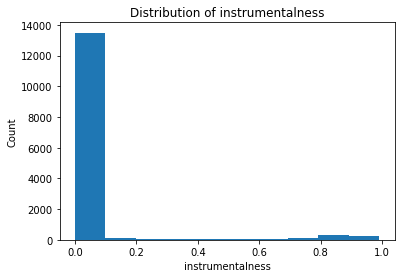

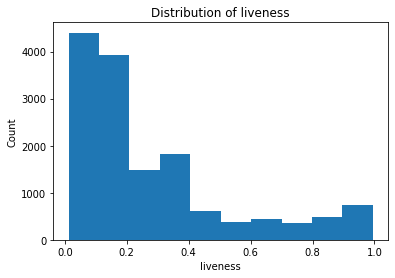

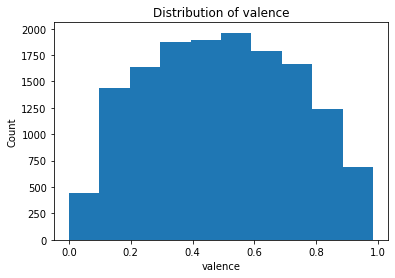

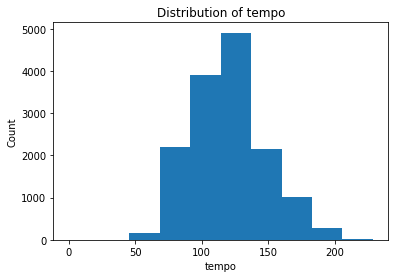

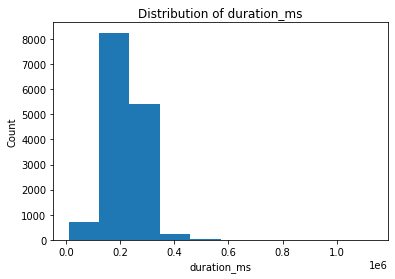

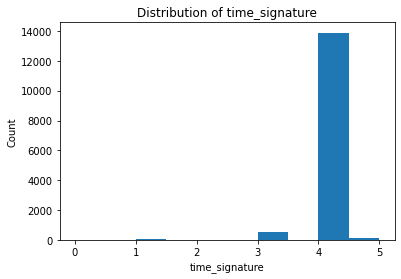

In [31]:
##Checking Distribution of Features
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

for feature in features:
    plt.hist(dataset[feature])
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title('Distribution of {feature}'.format(feature = feature))
    plt.show()

In [32]:
##Standardizing Values for Features
def standardize(column):
    col_max = dataset[column].max()
    col_min = dataset[column].min()
    dataset[column] = (dataset[column] - dataset[column].mean())/(dataset[column].std())

types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = dataset.select_dtypes(include = types)

for column in num_cols:
    standardize(column)

print(dataset.head())

   Artist               Artist_Id                 Album_Name  \
0  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
1  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
2  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
3  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   
4  H.O.T.  5JrfgZAgqAMywJpLpJM0eS  FOREVER 2001 LIVE CONCERT   

                 Album_Id                                        Track_Title  \
0  697cPaD568S5Zt4bgo4cQf                                     Opening - Live   
1  697cPaD568S5Zt4bgo4cQf                                      I yah! - Live   
2  697cPaD568S5Zt4bgo4cQf           Git It Up! / 전사의 후예 / You Got Gun - Live   
3  697cPaD568S5Zt4bgo4cQf                                Opening Ment - Live   
4  697cPaD568S5Zt4bgo4cQf  It's Been Raining Since You Left Me / Delight ...   

                 Track_Id  danceability    energy       key  loudness  \
0  6KOn7RweqUBSZWoKKkHFRb     -2.527586  1.214411  0.209859 -

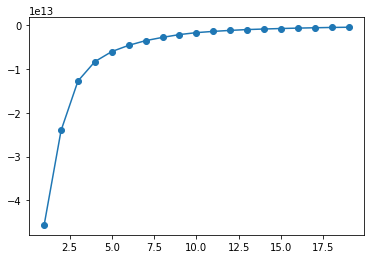

array([ 1,  8,  2, ...,  3, 17, 17], dtype=int32)

In [33]:
##find optimal number of clusters
score_list=[]
for i in range(1,20):

    model = KMeans(n_clusters=i)
    model.fit_predict(num_cols)
    score = model.score(num_cols)
    score_list.append(score)

plt.plot(range(1,20), score_list)
plt.scatter(range(1,20), score_list)
plt.show()
 ## shows that optimal number of clusters is approximately 5

cluster = KMeans(n_clusters = 5)
model.fit_predict(num_cols)

In [34]:
# Create class for song recommender
class Song_Recommender():

    def __init__(self, rec):
        self.rec_data = rec

    def change_data(self, rec):
        self.rec_data = rec
    
    def get_recommendations(self, track_title, amount=1):
        distance_lst = []
        song = self.rec_data [(self.rec_data.Track_Title.str.lower() == track_title.lower())].head(1).values[0]
        reset_data = self.rec_data[self.rec_data.Track_Title.str.lower()!= track_title.lower()]
        for rec_song in tqdm(reset_data.values):
            dist = 0
            for col in np.arange(len(reset_data.columns)):
                if not col in range(0,6):
                    dist = dist + np.absolute(float(song[col]) - float(rec_song[col]))
            distance_lst.append(dist)
        reset_data['distance'] = distance_lst
        reset_data = reset_data.sort_values('distance')
        cols = ['Artist', 'Track_Title']
        return reset_data[cols][:amount]

In [35]:
# Call Recommender
recommender = Song_Recommender(dataset)
recommender.get_recommendations('Love Shot', amount=5)

100%|██████████| 14627/14627 [00:00<00:00, 30766.60it/s]
/var/folders/w6/p_k21gdj2c18s78jpmws402r0000gn/T/ipykernel_45025/1251158066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reset_data['distance'] = distance_lst


,Artist,Track_Title
4259,EXO,Love Shot - Chinese Version
5472,MONSTA X,Nobody Else
10111,Microdot,PINNERDOWN (Feat. Donell Lewis)
4322,EXO,The Eve - Chinese Version
8956,Nafla,love business


In [36]:
## Aggregate metrics for groups
group_data = dataset.groupby('Artist').mean()
group_data['Artist'] = dataset['Artist']

                 danceability    energy       key  loudness      mode  \
Artist                                                                  
2AM                 -0.148061 -0.566387 -0.215157 -0.110193  0.473789   
2NE1                 0.221132  0.399674  0.120912  0.342808 -0.172321   
2PM                  0.415133  0.371084 -0.008628  0.552782 -0.173222   
4Minute              0.624394  0.564314  0.132863  0.658240 -0.005429   
A.C.E               -0.436437  0.266929  0.379250  0.418846 -0.233628   
...                       ...       ...       ...       ...       ...   
homieduel            0.835585 -0.378779  0.048168 -0.432239  0.023096   
iKON                -0.147396  0.462972 -0.228238  0.153031  0.331741   
lIlBOI (lilboi)      0.940869  0.220114  0.533241  0.158029 -0.119528   
pH-1                 1.094495 -0.552342  0.371550  0.095859  0.279820   
punchnello           0.747991  0.426576  0.033469  0.488478  0.419851   

                 speechiness  acousticness  instru

In [37]:
## Create class for group recommender
from tokenize import group


class Group_Recommender:
    def __init__(self, rec):
        self.rec_data = rec
    
    def change_data (self, rec):
        self.change_data = rec
    
    def get_recommendations(self, artist, amount = 1):
        distance_lst = []
        song = self.rec_data [(self.rec_data.Artist.str.lower() == artist.lower())].head(1).values[0]
        reset_data = self.rec_data[self.rec_data.Artist.str.lower()!= artist.lower()]
        for rec_song in tqdm(reset_data.values):
            dist = 0
            for col in np.arange(len(reset_data.columns)):
                if not col in range(0,6):
                    dist = dist + np.absolute(float(song[col]) - float(rec_song[col]))
            distance_lst.append(dist)
        reset_data['distance'] = distance_lst
        reset_data = reset_data.sort_values('distance')
        cols = ['Artist', 'Track_Title']
        return reset_data[cols][:amount]
    

group_recommender = Group_Recommender(group_data)
group_recommender.get_recommendations('BTS')

AttributeError: 'DataFrame' object has no attribute 'Artist'